In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
sns.set()
pd.set_option('chained_assignment', None)

### Import User Play/Purchase Data

In [2]:
df = pd.read_csv("Data/steam-200k.csv", names=['userID', 'gameName', 'behavior', 'playHours', 'NA'])
df.drop(columns=['NA'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userID     200000 non-null  int64  
 1   gameName   200000 non-null  object 
 2   behavior   200000 non-null  object 
 3   playHours  200000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.1+ MB


The data set includes a fith column that is populated by only 0, first step is to remove that column from the df.

### Check for NaN values
I got lucky with this data, there are no missing values

In [3]:
df.isna().sum()

userID       0
gameName     0
behavior     0
playHours    0
dtype: int64

### Examine Users and Games

In [4]:
df.gameName.value_counts().sort_values(ascending=False)

Dota 2                                           9682
Team Fortress 2                                  4646
Counter-Strike Global Offensive                  2789
Unturned                                         2632
Left 4 Dead 2                                    1752
                                                 ... 
Desktop Dungeons Soundtrack                         1
Desktop Dungeons Goatperson DLC                     1
Escape Dead Island                                  1
The Settlers Rise of an Empire Gold Edition         1
Soccertron                                          1
Name: gameName, Length: 5155, dtype: int64

In [5]:
df.gameName.value_counts().sort_values(ascending=False).mean()

38.797284190106694

There are 5155 unique games, and the average play time is 38.8 hrs

In [6]:
df.userID.value_counts().sort_values(ascending=False)

62990992     1573
33865373      949
11403772      906
30246419      901
47457723      855
             ... 
94751685        1
274602960       1
258327971       1
70373768        1
198709823       1
Name: userID, Length: 12393, dtype: int64

In [7]:
df.userID.value_counts().sort_values(ascending=False).mean()

16.138142499798274

There are 12393 unique users, and the average number of games each has played is 16.1.

Now lets look at an individual user's data.

In [8]:
user1 = df.loc[df.userID==62990992]
user1.sort_values(by='gameName', ascending=False).head(30)

,userID,gameName,behavior,playHours
120316,62990992,resident evil 4 / biohazard 4,purchase,1.0
120317,62990992,resident evil 4 / biohazard 4,play,4.2
121158,62990992,iBomber Defense Pacific,purchase,1.0
121488,62990992,Zoo Park,purchase,1.0
120622,62990992,Zombie Zoeds,purchase,1.0
120623,62990992,Zombie Zoeds,play,1.6
121487,62990992,Zombie Driver HD Apocalypse Pack,purchase,1.0
120390,62990992,Zombie Driver HD,purchase,1.0
120391,62990992,Zombie Driver HD,play,3.2
120690,62990992,Zeno Clash,purchase,1.0


There are multiple entries for many of the games for each user. All entries with behavior=play have the playHours column representing how many hours the user spent playing the game. All entries with behvior=purchase have playHours column set to 1.0. This value does not represent actual play hours. 


#### Isolate Different Behaviors and examine

In [9]:
df.behavior.value_counts()

purchase    129511
play         70489
Name: behavior, dtype: int64

In [10]:
df.loc[df.behavior=='purchase', 'playHours'].describe()

count    129511.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: playHours, dtype: float64

In [11]:
# Isolate actual game play hours and examine
playtime = df.loc[df.behavior!='purchase', 'playHours']
playtime.describe()

count    70489.000000
mean        48.878063
std        229.335236
min          0.100000
25%          1.000000
50%          4.500000
75%         19.100000
max      11754.000000
Name: playHours, dtype: float64

The play hour data looks pretty skewed, lets visualize it. Turns out the data is so skewed it's hard to visualize. Lets remove outliers more than 2.5 std away from the mean.

In [12]:
cuttoff = playtime.mean() + (2. * playtime.std())
cuttoff

507.54853523751314

In [13]:
playtime.loc[playtime>=cuttoff] = cuttoff
playtime.describe()

count    70489.000000
mean        34.231933
std         90.129497
min          0.100000
25%          1.000000
50%          4.500000
75%         19.100000
max        507.548535
Name: playHours, dtype: float64

<AxesSubplot:>

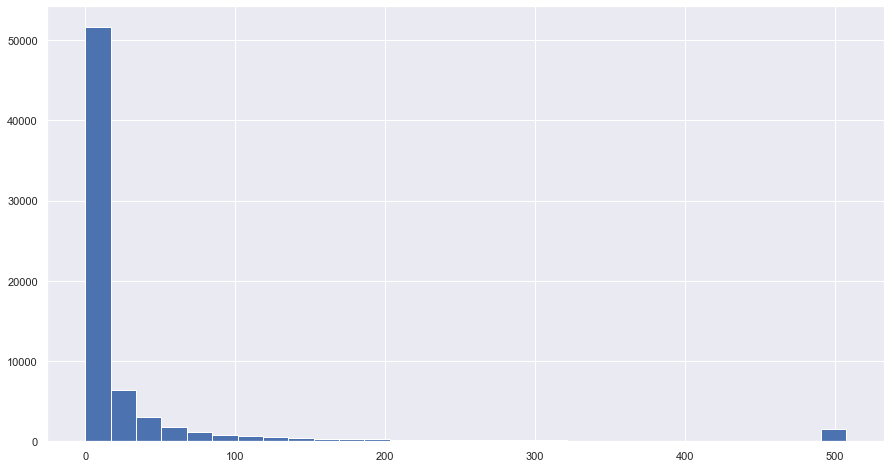

In [14]:
playtime.hist(bins=30, figsize=(15,8))

Play hours remain very skewed. This actually makes sense since not all games are designed to be played for the same amount of time. Some games are only ever meant to be played for a few short hours, while others are meant to be able to provide hundereds of hours of entertainment. A better way of looking at this would be to look at the distributions for different individual games. The issue with different games being designed for different play times can be solved by normalizing the play hours for each game. 

Lets look at the distributions for a few of the games individually.

<AxesSubplot:>

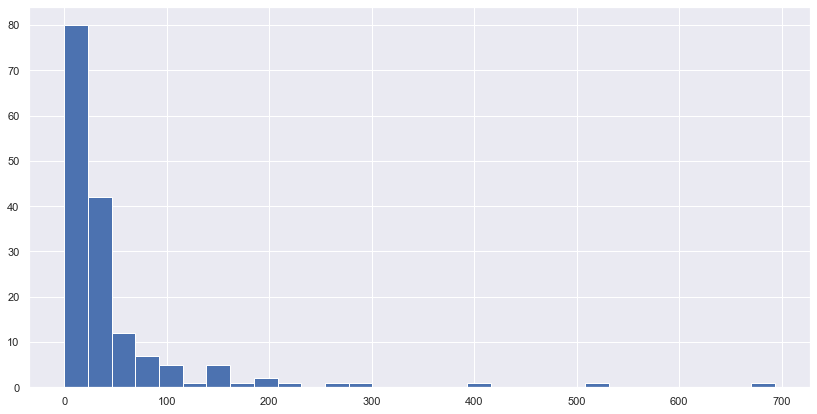

In [15]:
df.loc[(df.gameName=='XCOM Enemy Unknown') & (df.behavior=='play'), 'playHours'].hist(bins=30, figsize=(14,7))

We see that the play time is skewed on an individual game basis as well. 

### Remove the behavior column
Get rid of behavior column. Create a new one to indicate if a user purchased a game, and let the values in playHours only represent actual pay hours.

In [16]:
dfPlay = df.loc[df.behavior=='play']
dfPurchase = df.loc[df.behavior=='purchase']
dfPlay.head()

,userID,gameName,behavior,playHours
1,151603712,The Elder Scrolls V Skyrim,play,273.0
3,151603712,Fallout 4,play,87.0
5,151603712,Spore,play,14.9
7,151603712,Fallout New Vegas,play,12.1
9,151603712,Left 4 Dead 2,play,8.9


In [17]:
dfFull = dfPurchase.merge(dfPlay, how='outer', left_on=['userID', 'gameName'], right_on=['userID', 'gameName'])
dfFull.head(10)

,userID,gameName,behavior_x,playHours_x,behavior_y,playHours_y
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,play,273.0
1,151603712,Fallout 4,purchase,1.0,play,87.0
2,151603712,Spore,purchase,1.0,play,14.9
3,151603712,Fallout New Vegas,purchase,1.0,play,12.1
4,151603712,Left 4 Dead 2,purchase,1.0,play,8.9
5,151603712,HuniePop,purchase,1.0,play,8.5
6,151603712,Path of Exile,purchase,1.0,play,8.1
7,151603712,Poly Bridge,purchase,1.0,play,7.5
8,151603712,Left 4 Dead,purchase,1.0,play,3.3
9,151603712,Team Fortress 2,purchase,1.0,play,2.8


In [18]:
dfFull.drop(columns=['behavior_x', 'behavior_y'], inplace=True)
dfFull.columns = ['userID', 'gameName', 'purchase', 'playHours']
dfFull.head(10)

,userID,gameName,purchase,playHours
0,151603712,The Elder Scrolls V Skyrim,1.0,273.0
1,151603712,Fallout 4,1.0,87.0
2,151603712,Spore,1.0,14.9
3,151603712,Fallout New Vegas,1.0,12.1
4,151603712,Left 4 Dead 2,1.0,8.9
5,151603712,HuniePop,1.0,8.5
6,151603712,Path of Exile,1.0,8.1
7,151603712,Poly Bridge,1.0,7.5
8,151603712,Left 4 Dead,1.0,3.3
9,151603712,Team Fortress 2,1.0,2.8


In [19]:
# Fill all NaN values in playHours with 0, since these are games that were purchased but never played
dfFull.playHours = dfFull.playHours.fillna(value=0)

In [20]:
dfFull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129535 entries, 0 to 129534
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userID     129535 non-null  int64  
 1   gameName   129535 non-null  object 
 2   purchase   129535 non-null  float64
 3   playHours  129535 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.9+ MB


In [21]:
dfFull.shape

(129535, 4)

In [22]:
dfFull.loc[dfFull.playHours==0, 'playHours'].shape

(58750,)

In [23]:
dfFull.drop_duplicates(subset=['userID', 'gameName'], inplace=True)
dfFull = dfFull.loc[dfFull.playHours>0]

### Add Additional User Data gathered from steam API
Some friends aggreed to be included in my project. 

An unfortunate result of using kaggle data as my base user-item interaction data set is that the kaggle data is missing item id values. This presented a problem when linking data gathered from steam's api and the steamspy api with the data form kaggle. I needed to relly on game names rather than unique id values. The solution for this was to remove any special characters that were attached to the game names collected from api's. This solution worked well, but there were a small number of games that slipped through the cracks. In the future it would be a good idea to use FuzzyWuzzy to match game names instead.

In [24]:
def add_user(fullDF, userDF):
    
    userDF.rename(columns={'name':'gameName', 'playtime_forever':'playHours'}, inplace=True)
    
    userDF.gameName = userDF.gameName.str.replace(':', '')
    userDF.gameName = userDF.gameName.str.replace('Â®', '')
    userDF.gameName = userDF.gameName.str.replace('â„¢', '') 
    userDF.gameName = userDF.gameName.str.replace('®', '')
    userDF.gameName = userDF.gameName.str.replace('™', '')
    userDF.gameName = userDF.gameName.str.replace('- ', '')
    userDF.gameName = userDF.gameName.str.replace('-', '')
    userDF.gameName = userDF.gameName.apply(lambda x: x.lower())
    fullDF.gameName = fullDF.gameName.str.replace('- ', '')
    fullDF.gameName = fullDF.gameName.str.replace('-', '')
    fullDF.gameName = fullDF.gameName.apply(lambda x: x.lower())
    
    
    
    userDF = userDF.loc[userDF.gameName.isin(fullDF.gameName)]
    
    return pd.concat([fullDF, userDF], axis=0)

In [25]:
myDF = pd.read_csv('Data/APIdata/MyGames.csv')
myDF.shape, dfFull.shape

((188, 5), (70477, 4))

In [26]:
dfFull = add_user(dfFull, myDF)
dfFull.shape

(70596, 5)

In [27]:
f = pd.read_csv("Data/APIdata/friends.csv", index_col=0)
f.shape, dfFull.shape

((713, 5), (70596, 5))

In [28]:
dfFull = add_user(dfFull, f)
dfFull.shape

(71006, 5)

In [29]:
b1 = pd.read_csv("Data/APIdata/others_batch1.csv", index_col=0)
b1.shape, dfFull.shape

((65205, 5), (71006, 5))

In [30]:
dfFull = add_user(dfFull, b1)
dfFull.shape

(101864, 5)

In [31]:
b2 = pd.read_csv('Data/APIdata/others_batch2.csv', index_col=0)
b2.shape, dfFull.shape

((58253, 5), (101864, 5))

In [32]:
dfFull = add_user(dfFull, b2)
dfFull.shape

(127315, 5)

In [33]:
dfFull.drop_duplicates(subset=['userID', 'gameName'], inplace=True)

### Cap Outliers and Reduce Data for Modeling
The play hours data is still very skewed so capping outliesr at 1.5 IQR range seems like a good solution. 

Additionally, the data set is massive and very sparce, so reducing it to a smaller/denser set for model traing will both improve results and speed up the training process. 

In [34]:
FullMatrix = dfFull.pivot(index='userID', columns='gameName', values='playHours')
FullMatrix.shape, FullMatrix.size

((12022, 3600), 43279200)

In [35]:
# Reduce the size of the data by removing any user's who have played less than 25 games, and any games that have been played
# by less than 45 users.

reducedMatrix = FullMatrix.dropna(axis=1, thresh=45)
reducedMatrix.dropna(axis=0, thresh=25, inplace=True)

reducedMatrix.shape, reducedMatrix.size

((919, 627), 576213)

In [36]:
reducedMatrix.loc[:, 'the elder scrolls v skyrim'].max(), reducedMatrix.loc[:, 'dota 2'].max()

(1986.0, 5608.0)

In [37]:
# Remove outliers from play time for each game, by setting a cap min and max for each column using 1.5IQR
for i in reducedMatrix.columns:
    q2 = reducedMatrix[i].quantile(0.25)
    q3 = reducedMatrix[i].quantile(0.75)
    iqr = q3-q2

    
    reducedMatrix[i].clip(lower=(q2- (1.5*iqr)), upper=(q3 + (1.5*iqr)), inplace=True)

In [38]:
reducedMatrix.loc[:, 'the elder scrolls v skyrim'].max(), reducedMatrix.loc[:, 'dota 2'].max()

(312.7, 767.45)

In [39]:
reducedMatrix.reset_index(inplace=True)
reducedMatrix.head()

C:\Users\blake\AppData\Local\Temp/ipykernel_13136/2977043873.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reducedMatrix.reset_index(inplace=True)


gameName,userID,100% orange juice,7 days to die,8bitmmo,a story about my uncle,ace of spades,adventure capitalist,afterfall insanity extended edition,aftermath,age of chivalry,...,wolfenstein the new order,wolfenstein the old blood,world of goo,world of guns gun disassembly,worms armageddon,worms reloaded,worms revolution,xcom enemy unknown,yet another zombie defense,zombie panic source
0,298950,NaN,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN
1,561758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5
2,975449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,0.200,NaN,NaN,NaN,NaN,41.0,NaN,NaN
3,1936551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.975,NaN,NaN,1.3,NaN,NaN,NaN,NaN
4,1950243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
reducedDf = reducedMatrix.melt(id_vars='userID').dropna(subset='value')
reducedDf.head()

,userID,gameName,value
149,48028873,100% orange juice,1.8
310,88525821,100% orange juice,0.9
323,93644606,100% orange juice,3.1
381,115996656,100% orange juice,2.5
401,125017535,100% orange juice,0.7


In [41]:
dfFull = reducedDf.merge(dfFull, on=['userID', 'gameName'], how='left')
dfFull.head()

,userID,gameName,value,purchase,playHours,appid
0,48028873,100% orange juice,1.8,1.0,1.8,NaN
1,88525821,100% orange juice,0.9,1.0,0.9,NaN
2,93644606,100% orange juice,3.1,1.0,3.1,NaN
3,115996656,100% orange juice,2.5,1.0,2.5,NaN
4,125017535,100% orange juice,0.7,1.0,0.7,NaN


In [42]:
dfFull.drop(columns=['playHours'], inplace=True)
dfFull.rename(columns={'value':'playHours'}, inplace=True)
dfFull.head()

,userID,gameName,playHours,purchase,appid
0,48028873,100% orange juice,1.8,1.0,NaN
1,88525821,100% orange juice,0.9,1.0,NaN
2,93644606,100% orange juice,3.1,1.0,NaN
3,115996656,100% orange juice,2.5,1.0,NaN
4,125017535,100% orange juice,0.7,1.0,NaN


In [43]:
dfFull.loc[dfFull.gameName=='the elder scrolls v skyrim', 'playHours'].describe()

count    501.000000
mean      84.758649
std       94.624657
min        0.000000
25%        8.200000
50%       48.000000
75%      130.000000
max      312.700000
Name: playHours, dtype: float64

<AxesSubplot:>

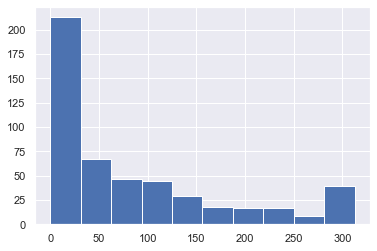

In [44]:
dfFull.loc[dfFull.gameName=='the elder scrolls v skyrim', 'playHours'].hist()

In [45]:
dfFull.shape

(60648, 5)

### Convert Implicit Ratings to Explicit
Done by scaling data for each game using MinMaxScaler, then for each user generating ratings for each game on a scale of 1-5 based on the mean ammount of time they spent playing all games.

In [46]:
temp = reducedMatrix.copy()
temp.index = temp['userID']
temp.drop(columns=['userID'], inplace=True)
temp.head()

gameName,100% orange juice,7 days to die,8bitmmo,a story about my uncle,ace of spades,adventure capitalist,afterfall insanity extended edition,aftermath,age of chivalry,age of empires ii hd edition,...,wolfenstein the new order,wolfenstein the old blood,world of goo,world of guns gun disassembly,worms armageddon,worms reloaded,worms revolution,xcom enemy unknown,yet another zombie defense,zombie panic source
userID,,,,,,,,,,,,,,,,,,,,,
298950,NaN,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN
561758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5
975449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,0.200,NaN,NaN,NaN,NaN,41.0,NaN,NaN
1936551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.975,NaN,NaN,1.3,NaN,NaN,NaN,NaN
1950243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
scaler = MinMaxScaler()
scaler.fit(temp)
tempScaled = pd.DataFrame(scaler.transform(temp), index=temp.index, columns=temp.columns)

In [48]:
tempScaled.head()

gameName,100% orange juice,7 days to die,8bitmmo,a story about my uncle,ace of spades,adventure capitalist,afterfall insanity extended edition,aftermath,age of chivalry,age of empires ii hd edition,...,wolfenstein the new order,wolfenstein the old blood,world of goo,world of guns gun disassembly,worms armageddon,worms reloaded,worms revolution,xcom enemy unknown,yet another zombie defense,zombie panic source
userID,,,,,,,,,,,,,,,,,,,,,
298950,NaN,0.218661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.342173,NaN,NaN
561758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123757
975449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103613,NaN,...,NaN,NaN,0.040201,NaN,NaN,NaN,NaN,0.561163,NaN,NaN
1936551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,NaN,NaN,0.158537,NaN,NaN,NaN,NaN
1950243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
tempScaled = tempScaled.T
tempScaled.head()

userID,298950,561758,975449,1936551,1950243,2083767,2110581,2259650,2643609,2753525,...,76561198067720402,76561198067720435,76561198067720449,76561198067720477,76561198067720489,76561198067720491,76561198067720499,76561198067720511,76561198067720527,76561198067720624
gameName,,,,,,,,,,,,,,,,,,,,,
100% orange juice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7 days to die,0.218661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.00000,NaN,NaN,0.056067,NaN,NaN,0.055048,NaN,NaN,NaN
8bitmmo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.038647,NaN,NaN,NaN,NaN,NaN
a story about my uncle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00000,NaN,NaN,NaN,NaN,NaN,0.356757,NaN,NaN,NaN
ace of spades,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.43057,NaN,NaN,NaN,NaN,0.550665,NaN,NaN,NaN,NaN


In [50]:
%%time
for i in tempScaled.columns.values:
    conds = [
        (tempScaled[i]>=1.7*tempScaled[i].mean()),
        (tempScaled[i]>=1.1*tempScaled[i].mean()) & (tempScaled[i]<1.7*tempScaled[i].mean()),
        (tempScaled[i]>=0.5*tempScaled[i].mean()) & (tempScaled[i]<1.1*tempScaled[i].mean()),
        (tempScaled[i]>=0.1*tempScaled[i].mean()) & (tempScaled[i]<0.5*tempScaled[i].mean()),
        (tempScaled[i]<0.1*tempScaled[i].mean())
    ]
    
    values = [5,4,3,2,1]
    tempScaled[i] = np.select(conds, values, default=np.nan)

Wall time: 1.76 s


In [51]:
tempScaled.head()

userID,298950,561758,975449,1936551,1950243,2083767,2110581,2259650,2643609,2753525,...,76561198067720402,76561198067720435,76561198067720449,76561198067720477,76561198067720489,76561198067720491,76561198067720499,76561198067720511,76561198067720527,76561198067720624
gameName,,,,,,,,,,,,,,,,,,,,,
100% orange juice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7 days to die,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN
8bitmmo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
a story about my uncle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
ace of spades,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


<AxesSubplot:>

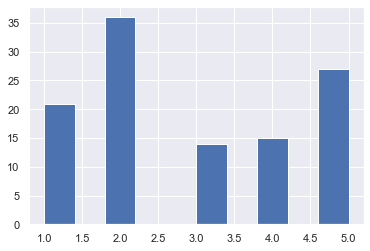

In [52]:
tempScaled[975449].hist()

In [53]:
tempScaled = tempScaled.T
tempScaled.reset_index(inplace=True)
tempScaled.head()

gameName,userID,100% orange juice,7 days to die,8bitmmo,a story about my uncle,ace of spades,adventure capitalist,afterfall insanity extended edition,aftermath,age of chivalry,...,wolfenstein the new order,wolfenstein the old blood,world of goo,world of guns gun disassembly,worms armageddon,worms reloaded,worms revolution,xcom enemy unknown,yet another zombie defense,zombie panic source
0,298950,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1,561758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,975449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN
3,1936551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
4,1950243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
tempDf = tempScaled.melt(id_vars='userID').dropna(subset='value')
tempDf.head()

,userID,gameName,value
149,48028873,100% orange juice,4.0
310,88525821,100% orange juice,2.0
323,93644606,100% orange juice,4.0
381,115996656,100% orange juice,5.0
401,125017535,100% orange juice,3.0


<AxesSubplot:>

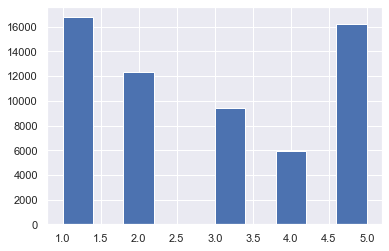

In [55]:
tempDf.value.hist()

In [316]:
tempDf.isna().sum()

userID      0
gameName    0
value       0
dtype: int64

In [317]:
dfFull = dfFull.merge(tempDf, how='left', on=['userID', 'gameName'])
dfFull.head()

,userID,gameName,playHours,purchase,appid,value
0,48028873,100% orange juice,1.8,1.0,NaN,4.0
1,88525821,100% orange juice,0.9,1.0,NaN,2.0
2,93644606,100% orange juice,3.1,1.0,NaN,4.0
3,115996656,100% orange juice,2.5,1.0,NaN,5.0
4,125017535,100% orange juice,0.7,1.0,NaN,3.0


In [318]:
dfFull.rename(columns={'value':'rating'}, inplace=True)
dfFull.head()

,userID,gameName,playHours,purchase,appid,rating
0,48028873,100% orange juice,1.8,1.0,NaN,4.0
1,88525821,100% orange juice,0.9,1.0,NaN,2.0
2,93644606,100% orange juice,3.1,1.0,NaN,4.0
3,115996656,100% orange juice,2.5,1.0,NaN,5.0
4,125017535,100% orange juice,0.7,1.0,NaN,3.0


In [319]:
dfFull.dropna(subset=['rating'], inplace=True)

In [320]:
dfFull.loc[dfFull.playHours==0].shape

(13330, 6)

In [321]:
dfFull.shape

(60648, 6)

### Import Game Data
Next we import game feature data obtained from kaggle

In [322]:
dfGames = pd.read_csv('Data/steam_games.csv')
dfGames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [323]:
dfGames.drop(columns=['release_date', 'required_age', 'steamspy_tags', 'achievements', 'median_playtime', 'owners'], inplace=True)
dfGames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   english           27075 non-null  int64  
 3   developer         27075 non-null  object 
 4   publisher         27075 non-null  object 
 5   platforms         27075 non-null  object 
 6   categories        27075 non-null  object 
 7   genres            27075 non-null  object 
 8   positive_ratings  27075 non-null  int64  
 9   negative_ratings  27075 non-null  int64  
 10  average_playtime  27075 non-null  int64  
 11  price             27075 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 2.5+ MB


In [324]:
# If I am going to use the review data (postive_ratings and negative_ratings), I need to generize it for each game
dfGames['PositiveReviewRatio'] = dfGames.positive_ratings / (dfGames.positive_ratings + dfGames.negative_ratings)
dfGames.drop(columns=['positive_ratings', 'negative_ratings'], inplace=True)

In [325]:
# Define a function for extracting dummy features for each column that contains munltiple categorical features
def dummies(df, col, delim):
    '''Generate dummy features for column, join the new features onto original df, and drop the original colum'''
    x = df[col]
    x = x.str.get_dummies(sep=delim)
    df = df.join(x)
    df.drop(columns=[col], inplace=True)
    return df

In [326]:
dfGames = dummies(dfGames, 'genres', ';')
dfGames = dummies(dfGames, 'categories', ';')
dfGames = dummies(dfGames, 'platforms', ';')

In [327]:
dfGames.head()

,appid,name,english,developer,publisher,average_playtime,price,PositiveReviewRatio,Accounting,Action,...,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled,linux,mac,windows
0,10,Counter-Strike,1,Valve,Valve,17612,7.19,0.973888,0,1,...,0,0,0,0,0,0,1,1,1,1
1,20,Team Fortress Classic,1,Valve,Valve,277,3.99,0.839787,0,1,...,0,0,0,0,0,0,1,1,1,1
2,30,Day of Defeat,1,Valve,Valve,187,3.99,0.895648,0,1,...,0,0,0,0,0,0,1,1,1,1
3,40,Deathmatch Classic,1,Valve,Valve,258,3.99,0.826623,0,1,...,0,0,0,0,0,0,1,1,1,1
4,50,Half-Life: Opposing Force,1,Gearbox Software,Valve,624,3.99,0.947996,0,1,...,0,0,0,0,0,0,1,1,1,1


### Join Game and User Data DF

This will be the matrix used for content based filtering.


First struggle is that the user data only came with game names, not IDs, and the naming conventions for some games do not match between the two data sources. Thankfully the differences are not in spelling, mainly just special characters and capitalizaion. To join the two df I will remove special characters where appropriate and make all names lower case.

In [328]:
dfGames.name = dfGames.name.str.replace(':', '')
dfGames.name = dfGames.name.str.replace('Â®', '')
dfGames.name = dfGames.name.str.replace('â„¢', '') 
dfGames.name = dfGames.name.str.replace('®', '')
dfGames.name = dfGames.name.str.replace('™', '')
dfGames.name = dfGames.name.str.replace('- ', '')
dfGames.name = dfGames.name.str.replace('-', '')
dfFull.gameName = dfFull.gameName.str.replace('- ', '')
dfFull.gameName = dfFull.gameName.str.replace('-', '')
dfGames.name = dfGames.name.apply(lambda x: x.lower())
dfFull.gameName = dfFull.gameName.apply(lambda x: x.lower())

In [329]:
# Merge behavior and game df
dfFull = dfFull.merge(dfGames, how='left', left_on='gameName', right_on='name')
dfFull.drop(columns=['name'], inplace=True)
dfFull.head(20)

,userID,gameName,playHours,purchase,appid_x,rating,appid_y,english,developer,publisher,...,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled,linux,mac,windows
0,48028873,100% orange juice,1.800000,1.0,NaN,4.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,88525821,100% orange juice,0.900000,1.0,NaN,2.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,93644606,100% orange juice,3.100000,1.0,NaN,4.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,115996656,100% orange juice,2.500000,1.0,NaN,5.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,125017535,100% orange juice,0.700000,1.0,NaN,3.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,152078939,100% orange juice,5.990076,1.0,NaN,5.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,172518437,100% orange juice,1.900000,1.0,NaN,4.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,76561198067695275,100% orange juice,0.000000,1.0,282800.0,1.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,76561198067696359,100% orange juice,0.000000,1.0,282800.0,1.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,76561198067696817,100% orange juice,5.990076,1.0,282800.0,5.0,282800.0,1.0,Orange_Juice,Fruitbat Factory,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [330]:
dfFull.loc[dfFull.appid_x.isna(), 'appid_x'] = dfFull.appid_y

In [331]:
dfFull.drop(columns=['appid_y'], inplace=True)
dfFull.rename(columns={'appid_x':'appid'}, inplace=True)
dfFull.head()

,userID,gameName,playHours,purchase,appid,rating,english,developer,publisher,average_playtime,...,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled,linux,mac,windows
0,48028873,100% orange juice,1.8,1.0,282800.0,4.0,1.0,Orange_Juice,Fruitbat Factory,1678.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,88525821,100% orange juice,0.9,1.0,282800.0,2.0,1.0,Orange_Juice,Fruitbat Factory,1678.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,93644606,100% orange juice,3.1,1.0,282800.0,4.0,1.0,Orange_Juice,Fruitbat Factory,1678.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,115996656,100% orange juice,2.5,1.0,282800.0,5.0,1.0,Orange_Juice,Fruitbat Factory,1678.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,125017535,100% orange juice,0.7,1.0,282800.0,3.0,1.0,Orange_Juice,Fruitbat Factory,1678.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [332]:
dfFull.isna().sum()

userID                          0
gameName                        0
playHours                       0
purchase                        0
appid                        6225
                            ...  
VR Support                  13492
Valve Anti-Cheat enabled    13492
linux                       13492
mac                         13492
windows                     13492
Length: 73, dtype: int64

It looks like around 13000 games in the user data set did not match up with any of the data in the game dataset. On closer inspection this has two main sources. The user data set includes game DLC, the game data does not. The other reason is that the game data is incoplete, meaning there are some games in the user data set that are not present in the game data set. This was later rectified by bringing in data from steam's api and the steamspy api in anouther notebook.

In [333]:
dfFull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60648 entries, 0 to 60647
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   userID                      60648 non-null  int64  
 1   gameName                    60648 non-null  object 
 2   playHours                   60648 non-null  float64
 3   purchase                    60648 non-null  float64
 4   appid                       54423 non-null  float64
 5   rating                      60648 non-null  float64
 6   english                     47156 non-null  float64
 7   developer                   47156 non-null  object 
 8   publisher                   47156 non-null  object 
 9   average_playtime            47156 non-null  float64
 10  price                       47156 non-null  float64
 11  PositiveReviewRatio         47156 non-null  float64
 12  Accounting                  47156 non-null  float64
 13  Action                      471

After looking at the shape of the new joined df, I noticed that it is around 30 entries longer than it was previously. This is likely due to duplicate name entries in the game df it was joined on. Check for these duplicates and drop them.

In [334]:
dupes = dfFull.duplicated(subset=['userID', 'gameName'], keep=False)
dfFull.loc[dupes, ['userID', 'gameName', 'playHours', 'appid']].head(20)

,userID,gameName,playHours,appid


It looks like my assumption was right.

In [335]:
dfFull.drop_duplicates(subset=['userID', 'gameName'], keep='first', inplace=True)

### Create Matrix for Collaboritive Filtering

In [336]:
dfUsers = dfFull.pivot(index='userID', columns='gameName', values='rating')
dfUsers.head()

gameName,100% orange juice,7 days to die,8bitmmo,a story about my uncle,ace of spades,adventure capitalist,afterfall insanity extended edition,aftermath,age of chivalry,age of empires ii hd edition,...,wolfenstein the new order,wolfenstein the old blood,world of goo,world of guns gun disassembly,worms armageddon,worms reloaded,worms revolution,xcom enemy unknown,yet another zombie defense,zombie panic source
userID,,,,,,,,,,,,,,,,,,,,,
298950,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
561758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
975449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN
1936551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
1950243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [337]:
dfUsers.to_csv('Data/collabMatrix.csv')

In [338]:
dfFull.to_csv('Data/ContentMatrix.csv')

In [339]:
dfFull.shape

(60648, 73)